#### Description: Scrape NeurIPs conference papers
##### Created: 19/04/24
##### Modified: 19/06/25

In [2]:
import feather
import os, sys
import numpy as np
import pandas as pd
import multiprocessing
from pyprind import ProgBar
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from utils.pdf_parser import PDFParser
from utils.section_processor import SectionProcessor

sys.path.append('../')

from libs.multiprocess import Multiprocessor

In [3]:
from threading import Timer

class TooLong(Exception):
    def __init__(self, m):
        self.message = m
    def __str__(self):
        return self.message 
    
class Watchdog:
    def __init__(self, timeout, user_exception):  # timeout in seconds
        self.exception = user_exception
        self.timeout = timeout
        self.handler = self.defaultHandler
        self.timer = Timer(self.timeout, self.handler)
        self.timer.start()

    def reset(self):
        self.timer.cancel()
        self.timer = Timer(self.timeout, self.handler)
        self.timer.start()

    def stop(self):
        self.timer.cancel()

    def defaultHandler(self):
        raise self.exception

- #### Extract the abstract for all years

In [4]:
# Setup an Exception to be triggered by the watchdog
tl = TooLong('Too Long')

def abstract_extractor(path):    
    try:
        dog = Watchdog(45, tl) # set the watchdog to trigger the too long exception after 45 seconds
        try:
            pdf = PDFParser(path)
            pdf.convert_pdf_to_txt()
            pdf.convert_text_to_ascii()

            pdf.get_abstract()
        except:
            return 'failed'
    except TooLong as ex:
        #print(ex)
        return 'failed'
    dog.stop() # stop the watchdog
        
    return pdf.clean_text(pdf.abstract)

- ### For some reason there are 2 papers for that failing the processing
    - I tried using the watch dog timer but the exceptions aren't handling correctly
    - As a hack, print the papers
    - Pop them from the list
    - And move on, bye felica

In [8]:
years = os.listdir('/mnt/netapp/nlp/nips/raw/')
for c,y in enumerate(years):
    print(c,y)

0 1988
1 1989
2 1990
3 1991
4 1992
5 1993
6 1994
7 1995
8 1996
9 1997
10 1998
11 1999
12 2000
13 2001
14 2002
15 2003
16 2004
17 2005
18 2006
19 2007
20 2008
21 2009
22 2010
23 2011
24 2012
25 2013
26 2014
27 2015
28 2016
29 2017
30 2018


In [ ]:
# years = years[17:]
years=['2004']
for y in years:
    print(y)
    path = '../nips/raw/' + y
    files = os.listdir(path)
    files = [os.path.join(path, f) for f in files]
    
    with multiprocessing.Pool(70) as p:
        abstracts = p.map(abstract_extractor, files)
    
    print('Finished Extracting')
    df = pd.DataFrame({'abstracts' : abstracts})
    
    print('Writting to output: ', '/mnt/netapp/nlp/nips/processed/' + str(y) + '.feather')
    df.to_feather('/mnt/netapp/nlp/nips/processed/' + str(y) + '.feather')

2004


Exception in thread Thread-123:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 1180, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-3-0c2e1fd60246>", line 26, in defaultHandler
    raise self.exception
TooLong: Too Long

Exception in thread Thread-123:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 1180, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-3-0c2e1fd60246>", line 26, in defaultHandler
    raise self.exception
TooLong: Too Long
Exception in thread Thread-123:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 1180, in run
    self.function(*self.args, **self.kwargs)


In [ ]:
# pdf = PDFParser(files[0])
# pdf.convert_pdf_to_txt()
# pdf.convert_text_to_ascii()
# pdf.get_abstract()
# abstract = pdf.clean_text(pdf.abstract)

# # pdf.ascii_text.find('\nAbstract')
# pdf.ascii_text.find('Introduction')

In [50]:
failed_idx = np.nonzero(~df.abstracts.apply(lambda x: len(x) > 1))
failed_idx = failed_idx[0]

print('{:31} {}'.format('Failed to get Abstract: ', len(failed_idx)))
print('{:30} {}'.format('Succesfully to got Abstract: ', len(df) - len(failed_idx)))

Failed to get Abstract:         2
Succesfully to got Abstract:   260


- ### Start exploring the text

In [7]:
def plot_hist_freq(labels, values):
    indexes = np.arange(len(labels))

    plt.figure(figsize=(10,10))
    plt.bar(indexes, values, align='center')
    
    # add labels
    plt.xticks(indexes, labels, rotation=45)
    plt.show()

In [8]:
sp = SectionProcessor('2018')

In [11]:
# all_words = sp.accumulate_all_words_in_section(df, 'abstracts')
# all_words = all_words.split(' ')

# top = 50
# all_words = sp.remove_stopwords(all_words)
# all_words = sp.remove_punctuation(all_words)
all_words = sp.remove_patterns(all_words)
labels, values = sp.count_occurrance(all_words)
print('Done')

Done


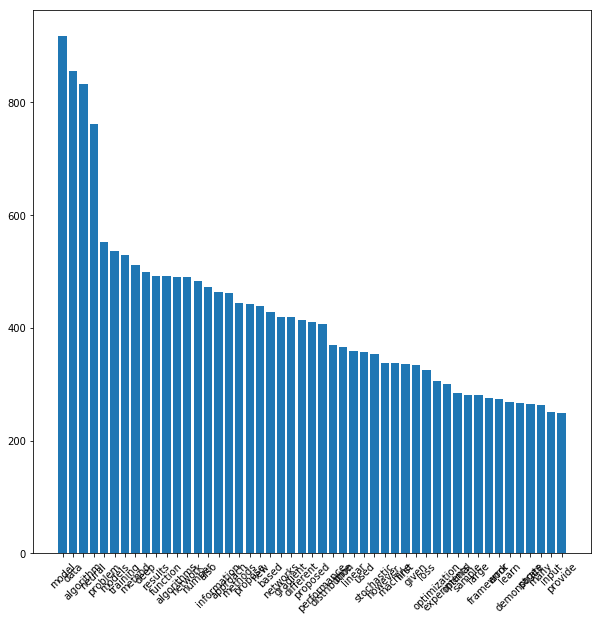

In [12]:
plot_hist_freq(labels[1:top], values[1:top])

In [13]:
top = 50
for l,v in zip(labels[1:top], values[1:top]):
    print('{:10} {}'.format(l, v))

model      917
data       855
algorithm  832
neural     760
problem    551
models     535
training   528
method     511
deep       498
results    492
function   491
algorithms 490
network    489
number     482
also       472
information 463
approach   461
methods    443
propose    442
new        439
based      427
networks   419
gradient   419
different  414
proposed   410
performance 407
distribution 370
time       366
linear     358
used       356
stochastic 353
however,   338
machine    338
first      336
given      334
loss       325
optimization 306
experiments 300
optimal    284
sample     281
large      280
framework  276
error      273
learn      268
demonstrate 266
pages      265
many       263
input      250
provide    249
